In this notebook, the main functionalities of the code written for "Counting and Hardness-of-Finding Fixed Points in Cellular Automata on Random Graphs" are presented.

For any questions, do not hesitate to contact the authors at cedric.koller@epfl.ch or kollerc98@gmail.com in the case the former adress is no longer in use.

## Requirements:

The belief propagation algorithm (BP) can be executed using only the standard python libraries and numpy. However, computing all the fixed points (see below) can be significantly quicker on a GPU. This was implemented using pytorch. Thus, installing pytorch and configuring the GPU accordingly (see https://pytorch.org/get-started/locally/ for instance) is recommended.

The population dynamics algorithm can be executed with the standard python libraries, numpy, matplotlib and scipy. A significanlty quicker and more precise version was implement on the GPU using pytorch. The used conda environment is attached.

## Constraint notation

The implementation supports all the possible nearest-neighbors constraints (or rule) with two cell types (occupied or inoccupied) on d-regular graphs. The constraint is given in a list. The first element of the list indicates the constraint when there are 0 occupied neighbors, the second element when there is 1 occupied neighbor, etc. Each element of a list is either '0', '1', '+', '-'. '0' indicates that the node must be unoccupied with the given number of neighbors. '1' indicates that it must be occupied with the given number of neighbors. '+' indicates that there is no constraint for the given number of neighbors, and '-' indicates that the constraint cannot be satisfied for the given number of neighbors.

As an example, the constraint to have at most $l$ occupied neighbors is written as follows:

$$
    [\underbrace{\overbrace{\text{'+', ... , '+'}}^l\text{,'0', ... ,'0'}}_{d+1}]
$$

# Replica symmetric solution using Belief Propagation

In this section, we present how the replica symmetric result is obtained.

### Instantiating BP

All the belief propagation computations are done using the class BP. The only obligatory parameter is the constraint.

In [4]:
# Importing the BP class
from src.BP import BP

In [5]:
# Instantiating BP
my_BP=BP(rule=['+', '+', '0', '0'])

In [6]:
# Looking at some properties before the run
my_BP

Instance of class 'BP'
Rule : ['+', '+', '0', '0']
μ =  0

Multiple optional parameters can be given, below is an example with all of them (with their default values).

In [7]:
my_BP_with_optional_parameters=BP(rule=['+', '+', '0', '0'], mu=0, tol=1e-12, max_iter=10000, max_iter_SP=500, tol_SP=1e-8, damping_parameter=0.8, init_message=None, SP_init='hard', seed=None, device='cuda')

The parameters are:
- mu: the chemical potential $\mu$
- tol: the tolerance at which the BP iterations stops
- max_iter: the maximum number of iterations before the algorithm stops (if the tolerance was not reached)
- max_iter_SP: maximum iteration of the Survey Propagation algorithm (not used in the paper)
- tol_SP: the tolerance at which the SP iteration stop (not used in the paper)
- damping_parameter: the fraction of damping introduced between each iteration
- init_message: the initial message in the format of a $2\times 2$ numpy array indicating the message. The matrix indexes $ij$ indicate the message that one node is in state $i$ and the other in state $j$. If None is given, each component of the message is initialized uniformly in $[0,1]$ and then normalized.
- SP_init: How the survey propagation messages are initialized (not used in the paper)
- seed: the seed for the random numbers generators
- device: the device used by pytorch. pytorch can do the computation on the cpu (if device='cpu'), but in that case it has no improvement over simply using numpy.


## Running BP

Doing one BP iteration is done using the 'step' function (the psi attribute is the current message):

In [8]:
print('Message before the step: ', my_BP.psi)
my_BP.step()
print('Message after the step: ', my_BP.psi)

Message before the step:  [[0.40224212 0.32509642]
 [0.02972034 0.24294112]]
Message after the step:  [[0.3720529  0.31033633]
 [0.09479047 0.2228203 ]]


A full run can be done as follwing:

In [9]:
for i in range(my_BP.max_iter):
    my_BP.step()
    if my_BP.diff()<my_BP.tol:
        print('Convergence reached after ', i+1, ' iterations !')
        break

Convergence reached after  107  iterations !


The diff() method computes the Frobenius norm between the previous and current message. Note that current message has dampening applied to it, so the tolerance must be decreased if a high dampening is applied.

Note that the message is replaced in the memory, so redoing the computation, convergence will be reached after one iteration:

In [10]:
for i in range(my_BP.max_iter):
    my_BP.step()
    if my_BP.diff()<my_BP.tol:
        print('Convergence reached after ', i+1, ' iterations !')
        break

Convergence reached after  1  iterations !


The observables (free energy density $\phi$, density $\rho$ and entropy density $s$) are obtained using

In [11]:
my_BP.update_observables()
print('Free entropy density :', my_BP.phi)
print('Density :', my_BP.rho)
print('Entropy density :', my_BP.s)

Free entropy density : 0.5512829976438371
Density : 0.3220275990016608
Entropy density : 0.5512829976438371


An overview can be obtained by simply printing the object:

In [12]:
my_BP

Instance of class 'BP'
Rule : ['+', '+', '0', '0']
μ =  0
φ = 0.5512829976438371
ρ = 0.3220275990016608
s = 0.5512829976438371

All this procedure can be simplified by using the 'run' method:

In [13]:
my_BP=BP(rule=['+','+','0','0'])
my_BP.run(verbose=True)
my_BP

Converged after  106  steps. Final error:  8.476340530408845e-13


Instance of class 'BP'
Rule : ['+', '+', '0', '0']
μ =  0
φ = 0.5512829976438374
ρ = 0.3220275990016609
s = 0.5512829976438374

The marginals are obtained using the 'marginals' function:

In [14]:
my_BP.marginals()

array([[0.41241702, 0.26555538],
       [0.26555538, 0.05647222]])

## An example from $\textit{Glass models on Bethe lattices}$

One possibility to reproduce figure 2 from $\textit{Glass models on Bethe lattices}$ (Rivoire et al, 2003) is

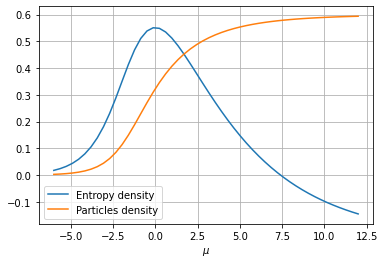

In [15]:
import numpy as np
import matplotlib.pyplot as plt

mu_list=np.linspace(-6,12,50)
s_list=[]
rho_list=[]
my_BP=BP(rule=['+','+','0','0'])

for mu in mu_list:
    my_BP.mu=mu
    my_BP.run()
    s_list.append(my_BP.s)
    rho_list.append(my_BP.rho)

# Plotting:
fig, ax=plt.subplots()
ax.plot(mu_list, s_list, label='Entropy density')
ax.plot(mu_list, rho_list, label='Particles density')
ax.legend()
ax.set_xlabel('$\mu$')
ax.grid();

## Grid search to find multiple fixed points

Doing a grid search to obtained multiple different fixed points can be done as follows

In [16]:
my_BP=BP(rule=['0','0','+','0'])
my_BP.find_all_fixed_points(grid_discretisation=20) # here each component of the message will take value 0, 0.05, 0.1, ..., 1

The fixed points and some of its properties can be obtained using

In [17]:
print('Fixed points:\n ',my_BP.fixed_points)
print('\nFree entropy density of the fixed points', my_BP.all_phi)

Fixed points:
  [[[3.00806768e-01 3.00806768e-01]
  [1.24598243e-01 2.73788220e-01]]

 [[5.00000000e-01 5.00000000e-01]
  [2.28122031e-21 0.00000000e+00]]]

Free entropy density of the fixed points [0.2045757755688038, 0.0]


The 'default' fixed point is the one with the largest free entropy.

For 'grid_discretisation' larger that ~40, it is more computationnaly effective to do the computation on a GPU using pytorch. To do so use

In [18]:
my_BP.find_all_fixed_points_torch(grid_discretisation=100, verbose=True)

/home/ckoller/anaconda3/envs/cedric_env/lib/python3.8/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /opt/conda/conda-bld/pytorch_1695392036766/work/torch/csrc/tensor/python_tensor.cpp:451.)
  _C._set_default_tensor_type(t)


Convergence reached for each starting initialisation after  240  steps !
Max error:  9.303691220347186e-13


### Saving and loading the results

The results can be saved as follows (as default in the results/[rule]/BP/ folder)

In [19]:
# my_BP.save()

The results can be loaded as follows

In [20]:
my_BP=BP(rule=['0','0','+','0'])
print('Before loading : \n', my_BP)
my_BP.load()
print('After loading : \n',my_BP)

Before loading : 
 Instance of class 'BP'
Rule : ['0', '0', '+', '0']
μ =  0
After loading : 
 Instance of class 'BP'
Rule : ['0', '0', '+', '0']
μ =  0
φ = 0.20457577556880358
ρ = 0.4677112744730745
s = 0.20457577556880358
Stability noisy fixed point in population dynamics: True
Linear susceptibility stability: True
Non-linear susceptibility stability: True
φ SP: 0.2045757755687988
Stability SP: False
φ SP noisy: -4.930380657631324e-32


# Population dynamics

## Instantiating population dynamics

Population dynamics is done using the 'population_dynamics' class. This class is deprecated compared to the 'population_dynamics_torch' running with torch used below, but allows for simulations using only numpy.

As before, the only required parameter is the constraint:

In [1]:
from src.population_dynamics import population_dynamics

In [22]:
my_pop=population_dynamics(rule=['+','+','0','0'])
my_pop

Instance of class 'population_dynamics'
Rule : ['+', '+', '0', '0']
μ =  0
Population size: 10000

All the possible optional parameters are:
- m: the Parisi parameter
- mu: the chemical potential $\mu$
- M: the size of the population
- num_samples: the number of samples used to compute the observables
- damping_parameter: the fraction of the population updated each iteration
- hard_fields: if True, the population is initialized on random hard fields, otherwise the population is initialized uniformly at random (and normalized)
- planted_messages: if not None, a fraction of the population will be initialized with the given message
- fraction_planted_messages: the fraction of the planted messages if 'planted_messages' is not None
- noise: the standard deviation of the gaussian noise applied to the planted messages. The default is 0 (no noise)
- impose_symmetry: if True, the unoccupied <-> occupied symmetry is enforced (default: False)
- max_iter: the maximum number of iterations
- tol: the tolerance before the iterations stop
- convergence_check_interval: the number of iterations between each convergence check
- sampling_threshold: the number of iterations before the sampling of the observables begins. The sampling will always do max_iter-sampling_threshold iterations.
- sampling_interval: the number of iterations between each sampling of the obersvables
- m_list: an array or list of the Parisi parameters to check for the complexity curves
- seed: the seed for the random number generator for reproductibility
    

### Running the population dynamics

The population dynamics can be run as follows:

In [23]:
for i in range(my_pop.max_iter):
    my_pop.step()
    if i%my_pop.convergence_check_interval==0:
        diff=my_pop.diff()
        print('Difference after ', i+1, 'iterations : ', diff)
        if diff<my_pop.tol:
            print('Early stopping ! Convergence of ', my_pop.tol, 'reached after ', i+1, 'iterations.')
            break

Difference after  1 iterations :  629.7999999999995
Difference after  201 iterations :  0.0
Early stopping ! Convergence of  10 reached after  201 iterations.


The 'diff' method computes the absolute difference between the histrograms of the population. This is relatively costly so not done at every iteration (see the 'convergence_check_interval' parameter). Note that as before the damping parameter plays a role in choosing the tolerance. However, the population size also plays a role since no normalization is done on the distribution to avoid additional computational costs, so the larger the population, the larger the tolerance should also be.

The message distribution can be visualized using

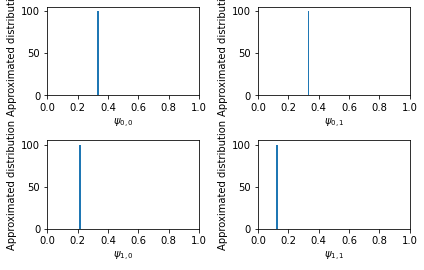

In [24]:
my_pop.draw_population()

In this case, the messages are peaked: we are in the RS phase and obtain the same results as BP.

The observables are sampled using

In [25]:
my_pop.update_observables()
print('Replicated free entropy density :', my_pop.psi)
print('Cluster free entropy density :', my_pop.phi)
print('Complexity :', my_pop.complexity)
print('Density :', my_pop.rho)
print('Entropy density: ', my_pop.s)

Replicated free entropy density : 0.5512829977182041
Cluster free entropy density : 0.5512829977182043
Complexity : -2.220446049250313e-16
Density : 0.32202759939727094
Entropy density:  0.5512829977182043


In the interesting cases (d1RSB and s1RSB phases), the population is however not peaked on the BP fixed point. To avoid the problem of fluctuating populations, we sample the observables multiple times (this is done with the parameters indicated above). All this is encompassed in the 'run' method. As an example take again $\textit{Glass models on Bethe lattices}$ (https://arxiv.org/pdf/cond-mat/0307569.pdf) where a RSB breaking appears from $\mu\approx 6.4$:

In [26]:
my_pop=population_dynamics(rule=['+','+','0','0'], mu=6.5)
my_pop.run(verbose=1)

Finished ! Final difference:  473.8


The observables can then be obtained from

In [27]:
print('Replicated free entropy density :', my_pop.psi_mean)
print('Cluster free entropy density :', my_pop.phi_mean)
print('Complexity :', my_pop.complexity_mean)
print('Density :', my_pop.rho_mean)
print('Entropy density: ', my_pop.s_mean)

Replicated free entropy density : 3.7578811220865416
Cluster free entropy density : 3.7561386037523445
Complexity : 0.001742518334196878
Density : 0.5724177395743043
Entropy density:  0.0354232965193661


An overview is given by

In [28]:
my_pop

Instance of class 'population_dynamics'
Rule : ['+', '+', '0', '0']
μ =  6.5
Population size: 10000
φ = 3.7561386037523445 +/- 0.028402351610013386
Σ = 0.001742518334196878 +/- 0.02416634029675933
Ψ = 3.7578811220865416 +/- 0.012289182237717137
ρ = 0.5724177395743043 +/- 0.01021387329394695
s = 0.0354232965193661 +/- 0.04579000092160817

This is a dynamical RSB, indeed the obtained value are the same (within the error margins) as BP:

In [29]:
my_BP=BP(rule=['+','+','0','0'], mu=6.5)
my_BP.run()
my_BP

Instance of class 'BP'
Rule : ['+', '+', '0', '0']
μ =  6.5
φ = 3.7583393904270728
ρ = 0.57081558497398
s = 0.0480380880962028

However, the population is  not trivial anymore:

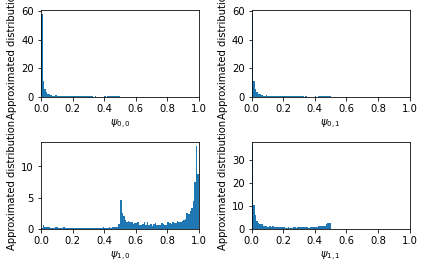

In [30]:
my_pop.draw_population()

### Static one-step replica symmetry breaking (s1RSB)

In the s1RSB case, the complexity curves must be computed to obtain the correct observables. This can be done using the 'compute_complexity_curves' function. One example where this happens is for $\mu>7$. Since there is a lot of noise, the population is increased. To avoid too long computation times, we use the class 'population_dynamics_torch' instead, which is the pytorch implementation of the 'population_dynamics' class.

In [1]:
from src.population_dynamics_torch import population_dynamics_torch

In [2]:
my_pop=population_dynamics_torch(rule=['+','+','0','0'], mu=15, M=1000000, num_samples=100000000)
my_pop.compute_complexity_curves(verbose=2)

========== m =  1e-05  ==========


/home/ckoller/anaconda3/envs/cedric_env/lib/python3.8/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /opt/conda/conda-bld/pytorch_1695392036766/work/torch/csrc/tensor/python_tensor.cpp:451.)
  _C._set_default_tensor_type(t)


Finished ! Final difference:  39.122
========== m =  0.03449241379310345  ==========
Finished ! Final difference:  36.698
========== m =  0.06897482758620689  ==========
Finished ! Final difference:  36.366
========== m =  0.10345724137931034  ==========
Finished ! Final difference:  35.962
========== m =  0.1379396551724138  ==========
Finished ! Final difference:  33.736000000000004
========== m =  0.17242206896551726  ==========
Finished ! Final difference:  32.472
========== m =  0.2069044827586207  ==========
Finished ! Final difference:  32.09
========== m =  0.24138689655172413  ==========
Finished ! Final difference:  29.608
========== m =  0.2758693103448276  ==========
Finished ! Final difference:  31.98
========== m =  0.31035172413793105  ==========
Finished ! Final difference:  28.022000000000002
========== m =  0.3448341379310345  ==========
Finished ! Final difference:  29.154
========== m =  0.3793165517241379  ==========
Finished ! Final difference:  26.342000000000002

/home/ckoller/anaconda3/envs/cedric_env/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


The obtained curves can be plotted as follows

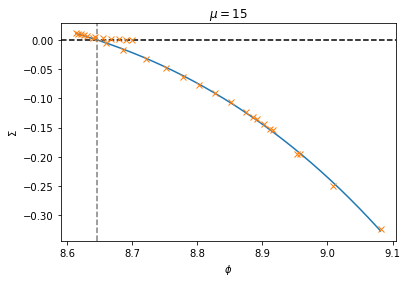

In [3]:
my_pop.draw_sigma_phi()

The intersection with $\Sigma=0$ gives the correct observables, which are stored as

In [4]:
print(my_pop.phi_s)
print(my_pop.rho_s)

8.645788627218543
0.5757415359399006


Computing the same using only the CPU (with a lower population) is not enough to draw the figure, but the obtained $\rho_s$ is still relatively close.

In [2]:
my_pop_no_torch=population_dynamics(rule=['+','+','0','0'], mu=15)
my_pop_no_torch.compute_complexity_curves(verbose=2)

========== m =  1e-05  ==========
Finished ! Final difference:  357.0
========== m =  0.03449241379310345  ==========
Finished ! Final difference:  359.20000000000005
========== m =  0.06897482758620689  ==========
Finished ! Final difference:  337.79999999999995
========== m =  0.10345724137931034  ==========
Finished ! Final difference:  327.79999999999995
========== m =  0.1379396551724138  ==========
Finished ! Final difference:  302.9999999999999
========== m =  0.17242206896551726  ==========
Finished ! Final difference:  270.99999999999994
========== m =  0.2069044827586207  ==========
Finished ! Final difference:  254.39999999999992
========== m =  0.24138689655172413  ==========
Finished ! Final difference:  244.2
========== m =  0.2758693103448276  ==========
Finished ! Final difference:  231.40000000000003
========== m =  0.31035172413793105  ==========
Finished ! Final difference:  232.7999999999999
========== m =  0.3448341379310345  ==========
Finished ! Final difference:

/home/ckoller/anaconda3/envs/cedric_env/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [3]:
my_pop_no_torch.rho_s

0.5719196906661804

### Saving and loading the results

The results can be saved as follows:

In [4]:
# my_pop.save()

By default, the population is not saved since the file can be very large. To save it use

In [5]:
# my_pop.save(save_population=True)

To load the results use

In [6]:
my_pop=population_dynamics(rule=['+','+','0','0'], mu=15)
print('Before loading:\n', my_pop)
my_pop.load()
print('\nAfter loading:\n', my_pop)

Before loading:
 Instance of class 'population_dynamics'
Rule : ['+', '+', '0', '0']
μ =  15
Population size: 10000

After loading:
 Instance of class 'population_dynamics'
Rule : ['+', '+', '0', '0']
μ =  15
Population size: 2000000
φ_s = 8.64502705763202
ρ_s = 0.5755851487081518


To also load the population use

In [7]:
# my_pop.load(load_population=True)

Note: the populations were not uploaded on github due to their significant size.

# Belief propagation on a given graph, Belief propagation reinforcement and local entropy

Belief propagation, belief propagation reinforcement and the computation of the local entropy is done within the class "graph_BP_regular_torch". The version using only numpy is not provided here and is deprecated, if interested the reader can contact the authors.

In [2]:
from src.graph_BP_regular_torch import *

In [3]:
BP_given_graph=graph_BP_regular_torch(rule=['+','+','0','0'], edges=None, N=50, mu=0, kappa=0, tol=1e-12, max_iter=10000, damping_parameter=0.8, init_messages=None, hard_fields=False, pi=0.25, gamma=0.1, seed=None, device='cuda')

As before, the only necessary parameter is the rule. The rest of the parameters are
- edges: a list of edges for the desired graph (the graph must be regular). If None is given, a random-d regular graph of N nodes is generated using a modified function of Networkx. Warning: generation for graphs above $N\approx 50000$ is slow.
- N: the number of nodes of the graph
- mu: the chemical potential
- kappa: The Lagrange parameter for the local entropy calculation
- tol: the tolerance for the BP iterations and for the BP calcuation of the local entropy
- max_iter: The maximal number of iterations for the BP, BP reinforcement and BP for local entropy algorithms.
- damping parameter: the damping parameter (the same damping is used in the 3 algorithms)
- init_messages: the intialisation of the messages. If None is given the initialisation is at random or on hard_fields (see following parameter)
- hard_fields: True: initialized on hard fields, False: initialized at random as in the previous BP algorithm
- pi: the hyperparameter $pi$ in the BP reinforcement algorithm
- gamma: the hyperparameter $\gamma$ in the BP reinforcement algorithm
- seed: random seed
- device: device used by pytorch

## Belief propagation on a given graph

To run BP, use

In [4]:
BP_given_graph.run()
BP_given_graph

Instance of class 'graph_BP_regular_torch'
Rule : ['+', '+', '0', '0']
N = 50
μ =  0
φ = 0.5512829976438371
ρ = 0.3220275990016607
s = 0.5512829976438371

Fraction hard fields : 0.0
Fraction i frozen : 0.0
Fraction at least one config forbidden : 0.0

## Belief propagation reinforcement

To run belief propagation reinforcement, use

In [5]:
BP_given_graph.reinforced_BP(verbose=2)

=========== Starting BP reinforcement for rule ['+', '+', '0', '0'] with pi =  0.25  ===========
# iter:  0   ||    # mistakes:  18   ||   BP convergence:  0.0804329498504249
Solution found after  9  iterations !


(tensor([False, False, False, False, False, False, False, False,  True, False,
         False, False, False,  True, False, False, False, False,  True,  True,
         False, False,  True, False, False, False, False, False, False, False,
          True,  True, False,  True, False,  True, False, False,  True, False,
         False,  True, False, False,  True, False, False, False, False, False],
        device='cuda:0'),
 True,
 8)

## Local entropy

The local entropy for a given Lagrange parameter $\kappa$ is computed using

In [6]:
BP_given_graph.run_LE()
print('We obtain a local entropy of ', BP_given_graph.local_entropy, ' at a distance ', BP_given_graph.distance)

We obtain a local entropy of  0.5512829976438371  at a distance  0.40745435148102116


Note that the object must have a solution (or at least a configuration) stored in its config attribute. To obtain the local entropy at a given distance using the adaptative algorithm, use

In [7]:
BP_given_graph.run_LE_adaptative(distance=0.1)
print('We obtain a local entropy of ', BP_given_graph.local_entropy, ' at a distance ', BP_given_graph.distance)

We obtain a local entropy of  0.2960250905294023  at a distance  0.10000000000474042


This can be done with multiple different distances to obtain Figure 3 (see below).

As for the previous examples, the results can be saved, but the procedure will no be described here.

## Automata network

The three previous classes have been included in the 'automata_network' class, which can automatically do the necessary calculation to compute the RS and 1RSB quantities, decide the phase, find solutions and compute the local entropy.

### Instantiating automata networks

The only obligatory parameter is again the rule:

In [1]:
from src.automata_network import automata_network

In [2]:
my_automata=automata_network(rule=['+','+','0','0'])

In [3]:
my_automata

Instance of class 'automata_network'

Instance of class 'BP'
Rule : ['+', '+', '0', '0']
μ =  0

Instance of class 'population_dynamics_torch'
Rule : ['+', '+', '0', '0']
μ =  0
Population size: 1000

By default the population dynamics uses the GPU, this can be changed by setting cuda=False as a parameter.

### Computing the phase

To compute the phase, use

In [ ]:
my_automata.RS_and_1RSB()
my_automata

In [ ]:
my_automata=automata_network(rule=['+','+','0','0'], mu=6.5)
my_automata.RS_and_1RSB()
my_automata

In [ ]:
my_automata=automata_network(rule=['+','+','0','0'], mu=15)
my_automata.RS_and_1RSB()
my_automata

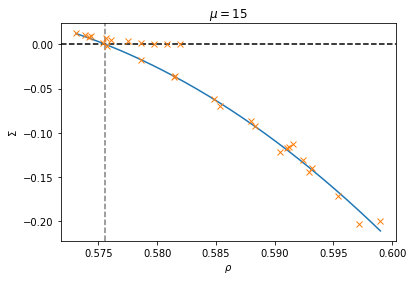

In [46]:
my_automata.population_dynamics.draw_sigma_rho()

This firstly does the grid search on all the BP fixed points and the population dynamics for $m=1$, and if needed searches for other $m\neq1$.

### Saving and loading the results

Saving is done as following:

In [47]:
my_automata.save()

Loading is done as following (by default the population and the graph is not saved):

In [6]:
my_automata=automata_network(rule=['+','+','0','0'])
print('Before loading :\n', my_automata)
my_automata.load()
print('\n\nAfter loading :', my_automata)

Before loading :
 Instance of class 'automata_network'

Instance of class 'BP'
Rule : ['+', '+', '0', '0']
μ =  0

Instance of class 'population_dynamics_torch'
Rule : ['+', '+', '0', '0']
μ =  0
Population size: 1000


After loading : Instance of class 'automata_network'

Phase: RS
Solution(s): Exponentially many with homogeneous stationary solutions

Instance of class 'BP'
Rule : ['+', '+', '0', '0']
μ =  0
φ = 0.5512829976438367
ρ = 0.32202759900166067
s = 0.5512829976438367
Stability noisy fixed point in population dynamics: True
Linear susceptibility stability: True
Non-linear susceptibility stability: True
φ SP: 2.2204460492503128e-16
Stability SP: True

Instance of class 'population_dynamics_torch'
Rule : ['+', '+', '0', '0']
μ =  0
Population size: 10000000
φ = 0.551284670829773 +/- 0.0
Σ = -8.344650268554688e-07 +/- 0.0
Ψ = 0.5512838363647461 +/- 0.0
ρ = 0.32202744483947754 +/- 0.0
s = 0.551284670829773 +/- 0.0

Fraction hard fields : 0.0
Fraction i frozen : 0.0
Fraction j fro

## Reproducing table 1, 2 and 3 (classification of the outer totalistic rules for d=3)

All the different constraints for d=3 can be obtained from

In [7]:
from src.automata_network import *
from utils.rules import *

In [2]:
rules=generate_independent_OT_rules(d=3)

Then we do the previous calculation on all the rules. We look for solutions if there are no homogeneous solutions and the rule is not locally contradictory

In [ ]:
for rule in rules:
    print('========== Rule : ', rule, '================')
    my_automata=automata_network(rule=rule)
    my_automata.RS_and_1RSB()
    my_automata.save(save_population=True)
    if my_automata.solutions=='Exponentially many with no homogeneous stationary solutions' or my_automata.solutions=='No stationary configuration but not locally contradictory' or my_automata.solutions=='Subexponentially many with no homogeneous stationary solutions':
        my_automata.BP_reinforcement()
        my_automata.save(save_population=True)

Creating the table:

In [3]:
locally_contradictory=[]
No_stationary_but_not_locally_contradictory=[]
subexp_no_homo=[]
only_homo=[]
subexp_with_homo=[]
exp_no_homo=[]
exp_with_homo=[]
for rule in rules:
    automata=automata_network(rule=rule)
    automata.load()
    if automata.solutions=='locally contradictory':
        locally_contradictory.append(automata.rule)
    elif automata.solutions=='No stationary configuration but not locally contradictory' or automata.solutions=='No stationary solutions but not locally contradictory':
        No_stationary_but_not_locally_contradictory.append(automata.rule)
    elif automata.solutions=='Subexponentially many with no homogeneous stationary solutions':
        subexp_no_homo.append(automata.rule)
    elif automata.solutions=='Only homogeneous stationary solutions':
        only_homo.append(automata.rule)
    elif automata.solutions=='Subexponentially many with homogeneous stationary solutions':
        subexp_with_homo.append(automata.rule)
    elif automata.solutions=='Exponentially many with no homogeneous stationary solutions':
        exp_no_homo.append(automata.rule)
    elif automata.solutions=='Exponentially many with homogeneous stationary solutions':
        exp_with_homo.append(automata.rule)
    else:
        print(rule, automata.solutions)

In [4]:
exp_no_homo

[['-', '0', '+', '0'],
 ['-', '0', '+', '-'],
 ['-', '+', '0', '0'],
 ['-', '+', '0', '-'],
 ['-', '+', '+', '0'],
 ['-', '+', '+', '-'],
 ['-', '+', '1', '0'],
 ['-', '1', '+', '0'],
 ['-', '1', '1', '0'],
 ['1', '0', '0', '0'],
 ['1', '0', '+', '0'],
 ['1', '+', '0', '0'],
 ['1', '+', '+', '0'],
 ['1', '+', '-', '0'],
 ['1', '1', '0', '0']]

In [5]:
locally_contradictory

[['-', '0', '0', '0'],
 ['-', '0', '0', '-'],
 ['-', '0', '-', '0'],
 ['-', '0', '-', '-'],
 ['-', '-', '0', '0'],
 ['-', '-', '0', '-'],
 ['-', '-', '-', '0'],
 ['-', '-', '-', '-']]

In [6]:
No_stationary_but_not_locally_contradictory

[['-', '0', '1', '0'],
 ['-', '0', '1', '-'],
 ['-', '+', '-', '0'],
 ['-', '+', '-', '-'],
 ['-', '-', '+', '0'],
 ['-', '-', '1', '0'],
 ['-', '1', '0', '0'],
 ['-', '1', '0', '-'],
 ['-', '1', '-', '0'],
 ['1', '0', '-', '0'],
 ['1', '-', '0', '0'],
 ['1', '-', '-', '0']]

In [7]:
subexp_no_homo

[['1', '0', '1', '0']]

In [8]:
only_homo

[['0', '0', '0', '0'],
 ['0', '0', '0', '+'],
 ['0', '0', '0', '-'],
 ['0', '0', '0', '1'],
 ['0', '0', '-', '0'],
 ['0', '0', '-', '+'],
 ['0', '0', '-', '-'],
 ['0', '0', '-', '1'],
 ['0', '-', '0', '0'],
 ['0', '-', '0', '+'],
 ['0', '-', '0', '-'],
 ['0', '-', '0', '1'],
 ['0', '-', '+', '0'],
 ['0', '-', '+', '-'],
 ['0', '-', '-', '0'],
 ['0', '-', '-', '+'],
 ['0', '-', '-', '-'],
 ['0', '-', '-', '1'],
 ['0', '-', '1', '0'],
 ['0', '-', '1', '-'],
 ['0', '1', '0', '-'],
 ['0', '1', '-', '0'],
 ['0', '1', '-', '+'],
 ['0', '1', '-', '-'],
 ['0', '1', '1', '-'],
 ['+', '-', '0', '-'],
 ['+', '-', '-', '0'],
 ['+', '-', '-', '+'],
 ['+', '-', '-', '-'],
 ['+', '-', '1', '0'],
 ['+', '-', '1', '-'],
 ['+', '1', '-', '0'],
 ['+', '1', '-', '-'],
 ['+', '1', '1', '-']]

In [9]:
subexp_with_homo

[['0', '1', '0', '1'], ['+', '-', '+', '-']]

In [10]:
exp_no_homo

[['-', '0', '+', '0'],
 ['-', '0', '+', '-'],
 ['-', '+', '0', '0'],
 ['-', '+', '0', '-'],
 ['-', '+', '+', '0'],
 ['-', '+', '+', '-'],
 ['-', '+', '1', '0'],
 ['-', '1', '+', '0'],
 ['-', '1', '1', '0'],
 ['1', '0', '0', '0'],
 ['1', '0', '+', '0'],
 ['1', '+', '0', '0'],
 ['1', '+', '+', '0'],
 ['1', '+', '-', '0'],
 ['1', '1', '0', '0']]

In [11]:
exp_with_homo

[['0', '0', '+', '0'],
 ['0', '0', '+', '+'],
 ['0', '0', '+', '-'],
 ['0', '0', '+', '1'],
 ['0', '0', '1', '0'],
 ['0', '0', '1', '+'],
 ['0', '0', '1', '-'],
 ['0', '0', '1', '1'],
 ['0', '+', '0', '0'],
 ['0', '+', '0', '+'],
 ['0', '+', '0', '-'],
 ['0', '+', '0', '1'],
 ['0', '+', '+', '0'],
 ['0', '+', '+', '+'],
 ['0', '+', '+', '-'],
 ['0', '+', '+', '1'],
 ['0', '+', '-', '0'],
 ['0', '+', '-', '+'],
 ['0', '+', '-', '-'],
 ['0', '+', '-', '1'],
 ['0', '+', '1', '0'],
 ['0', '+', '1', '+'],
 ['0', '+', '1', '-'],
 ['0', '-', '+', '+'],
 ['0', '-', '1', '+'],
 ['0', '1', '0', '0'],
 ['0', '1', '0', '+'],
 ['0', '1', '+', '0'],
 ['0', '1', '+', '+'],
 ['0', '1', '+', '-'],
 ['0', '1', '1', '0'],
 ['0', '1', '1', '+'],
 ['+', '0', '0', '0'],
 ['+', '0', '0', '+'],
 ['+', '0', '0', '-'],
 ['+', '0', '+', '0'],
 ['+', '0', '+', '+'],
 ['+', '0', '+', '-'],
 ['+', '0', '-', '0'],
 ['+', '0', '-', '+'],
 ['+', '0', '-', '-'],
 ['+', '0', '1', '0'],
 ['+', '0', '1', '+'],
 ['+', '0',

In [13]:
from tabulate import tabulate
import math

In [14]:
rule_=[]
phase_=[]
phi_RS_=[]
psi_=[]
phi_=[]
sigma_=[]
phi_s=[]
rounding=3
for rule in exp_no_homo:
    automata=automata_network(rule=rule)
    automata.load()
    rule_.append(str(rule).replace('[','(').replace(']',')').replace('\'','').replace(' ',''))
    if (automata.phase=='l1RSB' or automata.phase=='r1RSB' or automata.phase=='d1RSB') and automata.population_dynamics.stability==False:
        phase_.append(r'\textit{'+automata.phase+'}')
    elif automata.phase=='RS' and automata.BP.stability_AT==False:
        phase_.append(r'\textit{'+automata.phase+'}')
    else:
        phase_.append(automata.phase)

    phi_RS_.append(str("{:.3f}".format(automata.BP.phi))) if automata.BP.stability_AT and automata.BP.physical else phi_RS_.append(r'\textit{'+str("{:.3f}".format(automata.BP.phi))+'}')
    if automata.phase!='RS' and not math.isnan(automata.population_dynamics.psi_mean) and not math.isinf(automata.population_dynamics.psi_mean):
        psi_.append(str("{:.3f}".format(automata.population_dynamics.psi_mean))) if automata.population_dynamics.stability else psi_.append(r'\textit{'+str("{:.3f}".format(automata.population_dynamics.psi_mean))+'}')
        phi_.append(str("{:.3f}".format(automata.population_dynamics.phi_mean))) if automata.population_dynamics.stability else phi_.append(r'\textit{'+str("{:.3f}".format(automata.population_dynamics.phi_mean))+'}')
        sigma_.append(str("{:.3f}".format(automata.population_dynamics.complexity_mean))) if automata.population_dynamics.stability else sigma_.append(r'\textit{'+str("{:.3f}".format(automata.population_dynamics.complexity_mean))+'}')
    else:
        psi_.append('')
        phi_.append('')
        sigma_.append('')
    if automata.phase=='s1RSB':
        phi_s.append(str("{:.3f}".format(automata.population_dynamics.phi_s)))
    else:
        phi_s.append('')

    print(rule, automata.phase, automata.BP.phi, automata.BP.stability_AT, automata.BP.analytic_stability(), automata.population_dynamics.psi, automata.population_dynamics.phi, automata.population_dynamics.complexity, automata.population_dynamics.stability, automata.BP.phi_SP, automata.BP.stability_SP, automata.BP.phi_SP_noisy)

['-', '0', '+', '0'] l1RSB 0.10158630792724122 True (False, True) 0.10136115550994873 -0.004733920097351074 0.1060950756072998 False 0.10158630792724432 False -4.930380657631324e-32
['-', '0', '+', '-'] l1RSB 0.05229014029480261 True (False, True) 0.05223846435546875 0.000917971134185791 0.05132049322128296 False 0.0522901402948055 False 0.05197821989717677
['-', '+', '0', '0'] RS 0.21906497551099058 True (False, True) 0.21906530857086182 0.21906495094299316 3.5762786865234375e-07 True -4.930380657631324e-32 True None
['-', '+', '0', '-'] RS 0.15406870832503294 True (False, True) 0.1540682315826416 0.15406811237335205 1.1920928955078125e-07 True -1.1102230246251563e-16 True None
['-', '+', '+', '0'] RS 0.4880422664954711 True (True, True) 0.48804354667663574 0.48804402351379395 -4.76837158203125e-07 True 5.551115123125783e-17 True None
['-', '+', '+', '-'] RS 0.40546510810816416 True (False, True) 0.40546512603759766 0.40546417236328125 9.5367431640625e-07 True -1.1102230246251563e-16 

In [15]:
def str_with_err(value, error):
    if error>0:
        digits = -int(math.floor(math.log10(error)))
        if digits<=6:
            return "{0:.{2}f}({1:.0f})".format(value, error*10**digits, digits)
    return str("{:.4f}".format(value))

In [53]:
rule_=[]
phase_=[]
phi_RS_=[]
psi_=[]
phi_=[]
sigma_=[]
phi_s=[]
rounding=3
for rule in exp_no_homo:
    automata=automata_network(rule=rule)
    automata.load()
    rule_.append(str(rule).replace('[','(').replace(']',')').replace('\'','').replace(' ',''))
    if (automata.phase=='l1RSB' or automata.phase=='r1RSB' or automata.phase=='d1RSB') and automata.population_dynamics.stability==False:
        phase_.append(r'\textit{'+automata.phase+'}')
    elif automata.phase=='RS' and (automata.BP.stability_AT==False or automata.BP.physical==False):
        phase_.append(r'\textit{'+automata.phase+'}')
    else:
        phase_.append(automata.phase)

    if automata.BP.phi>-25:
        phi_RS_.append(str("{:.4f}".format(automata.BP.phi))) if automata.BP.stability_AT and automata.BP.physical else phi_RS_.append(r'\textit{'+str("{:.4f}".format(automata.BP.phi))+'}')
    else:
        phi_RS_.append(r'-\infty')
    if automata.phase!='RS' and not math.isnan(automata.population_dynamics.psi_mean) and not math.isinf(automata.population_dynamics.psi_mean):
        automata.load(load_population=True)
        if automata.population_dynamics.fraction_i_frozen==1.:
            automata.population_dynamics.phi_mean=0
            automata.population_dynamics.phi_std=0
            automata.population_dynamics.complexity_mean=automata.population_dynamics.psi_mean
            automata.population_dynamics.complexity_std=automata.population_dynamics.psi_std
        psi_.append(str_with_err(automata.population_dynamics.psi_mean, automata.population_dynamics.psi_std)) if automata.population_dynamics.stability else psi_.append(r'\textit{'+str_with_err(automata.population_dynamics.psi_mean, automata.population_dynamics.psi_std)+'}')
        phi_.append(str_with_err(automata.population_dynamics.phi_mean, automata.population_dynamics.phi_std)) if automata.population_dynamics.stability else phi_.append(r'\textit{'+str_with_err(automata.population_dynamics.phi_mean, automata.population_dynamics.phi_std)+'}')
        sigma_.append(str_with_err(automata.population_dynamics.complexity_mean, automata.population_dynamics.complexity_std)) if automata.population_dynamics.stability else sigma_.append(r'\textit{'+str_with_err(automata.population_dynamics.complexity_mean, automata.population_dynamics.complexity_std)+'}')
    else:
        psi_.append('')
        phi_.append('')
        sigma_.append('')
    if automata.phase=='s1RSB':
        phi_s.append(str("{:.4f}".format(automata.population_dynamics.phi_s)))
    else:
        phi_s.append('')

    print(rule, automata.phase, automata.BP.phi, automata.BP.stability_AT, automata.BP.analytic_stability(), automata.population_dynamics.psi, automata.population_dynamics.phi, automata.population_dynamics.complexity, automata.population_dynamics.stability, automata.BP.phi_SP, automata.BP.stability_SP, automata.BP.phi_SP_noisy)

['-', '0', '+', '0'] l1RSB 0.10158630792724122 True (False, True) 0.10136115550994873 -0.004733920097351074 0.1060950756072998 False 0.10158630792724432 False -4.930380657631324e-32
['-', '0', '+', '-'] l1RSB 0.05229014029480261 True (False, True) 0.05223846435546875 0.000917971134185791 0.05132049322128296 False 0.0522901402948055 False 0.05197821989717677
['-', '+', '0', '0'] RS 0.21906497551099058 True (False, True) 0.21906530857086182 0.21906495094299316 3.5762786865234375e-07 True -4.930380657631324e-32 True None
['-', '+', '0', '-'] RS 0.15406870832503294 True (False, True) 0.1540682315826416 0.15406811237335205 1.1920928955078125e-07 True -1.1102230246251563e-16 True None
['-', '+', '+', '0'] RS 0.4880422664954711 True (True, True) 0.48804354667663574 0.48804402351379395 -4.76837158203125e-07 True 5.551115123125783e-17 True None
['-', '+', '+', '-'] RS 0.40546510810816416 True (False, True) 0.40546512603759766 0.40546417236328125 9.5367431640625e-07 True -1.1102230246251563e-16 

In [54]:
# Generate LaTeX table
data=[rule_, phase_, phi_RS_, phi_, sigma_, phi_s]
data = list(zip(*data))

latex_table = tabulate(data, tablefmt='latex_raw',  floatfmt=".4f")

# Print the LaTeX table
print(latex_table)

\begin{tabular}{llrlll}
\hline
 (-,0,+,0) & \textit{l1RSB} & 0.1016 & \textit{0.0000}    & \textit{0.1016(2)} &  \\
 (-,0,+,-) & \textit{l1RSB} & 0.0523 & \textit{0.0000}    & \textit{0.0523(2)} &  \\
 (-,+,0,0) & RS             & 0.2191 &                    &                    &  \\
 (-,+,0,-) & RS             & 0.1541 &                    &                    &  \\
 (-,+,+,0) & RS             & 0.4880 &                    &                    &  \\
 (-,+,+,-) & RS             & 0.4055 &                    &                    &  \\
 (-,+,1,0) & \textit{r1RSB} & 0.2149 & \textit{0.0816(3)} & \textit{0.1332(3)} &  \\
 (-,1,+,0) & RS             & 0.3551 &                    &                    &  \\
 (-,1,1,0) & RS             & 0.1893 &                    &                    &  \\
 (1,0,0,0) & RS             & 0.2617 &                    &                    &  \\
 (1,0,+,0) & \textit{r1RSB} & 0.2845 & \textit{0.1460(4)} & \textit{0.1384(4)} &  \\
 (1,+,0,0) & RS             & 0.44

## Loading rule +-00 and drawing the complexity curve (fig.2 right)

In [3]:
automata=automata_network(rule=['+','-','0','0'])
automata.load()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


-37.78186020660782 101.45564787981061 -63.662276653849155 1.0


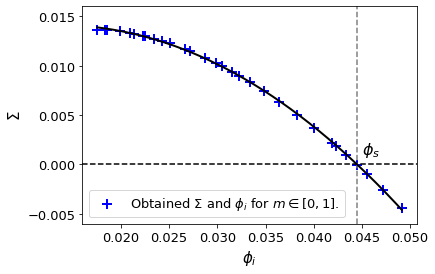

In [7]:
font = {'family' : ' DejaVu Sans',
        'size'   : 13}

plt.rc('font', **font)
plt.rc('axes', labelsize=15)

f, ax=plt.subplots()
#ax.set_title("Complexity curve rule (+,-,0,0)")

ax.axhline(0, linestyle='--', color='k', markersize=1)
ax.axvline(automata.population_dynamics.phi_s, linestyle='--', color='grey', markersize=1)
print(*automata.population_dynamics.fitting_param_phi)
samples=np.linspace(min(automata.population_dynamics.phi_list),max(automata.population_dynamics.phi_list),1000)
ax.plot(samples, fitting_func(samples, *automata.population_dynamics.fitting_param_phi), color='k', linewidth=2) # label=r'Fit $\Sigma(\phi_i)=-37+99\cdot 2^{\phi_i}-62\cdot3^{\phi_i}$'
ax.scatter(automata.population_dynamics.phi_list, automata.population_dynamics.complexity_list, marker='+', color='b',linewidths=2, s=100, label=r'Obtained $\Sigma$ and $\phi_i$ for $m\in[0,1]$.')
plt.text(0.045, 0.001, r'$\phi_s$', fontsize=16)

ax.set_ylim([-0.006, 0.016])

ax.legend()
ax.set_xlabel(r'$\phi_i$')
ax.set_ylabel(r'$\Sigma$');
plt.savefig('complexity_curve.eps', dpi=300, bbox_inches = "tight")

In [40]:
# Checking the stability of the fixed point at phi_s:
pop=population_dynamics_torch(rule=['+','-','0','0'], m=8.62070345e-01)

Instance of class 'population_dynamics_torch'
Rule : ['+', '-', '0', '0']
μ =  0
Population size: 10000000

In [41]:
pop.run()

/home/ckoller/anaconda3/envs/cedric_env/lib/python3.8/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /opt/conda/conda-bld/pytorch_1695392036766/work/torch/csrc/tensor/python_tensor.cpp:451.)
  _C._set_default_tensor_type(t)


Difference after  1 iterations :  3794.826
Difference after  201 iterations :  88.60000000000001
Difference after  401 iterations :  91.392
Difference after  601 iterations :  96.678
Difference after  801 iterations :  84.434
Difference after  1001 iterations :  88.456
Difference after  1201 iterations :  91.69800000000001
Difference after  1401 iterations :  93.27
Difference after  1601 iterations :  91.388
Difference after  1801 iterations :  95.45
Difference after  2001 iterations :  92.018
Difference after  2201 iterations :  88.934
Difference after  2401 iterations :  94.604
Difference after  2601 iterations :  98.36200000000001
Difference after  2801 iterations :  90.194
Difference after  3001 iterations :  94.53
Difference after  3201 iterations :  91.132
Difference after  3401 iterations :  88.97200000000001
Difference after  3601 iterations :  100.368
Difference after  3801 iterations :  91.25
Difference after  4001 iterations :  90.51
Difference after  4201 iterations :  91.8

In [44]:
pop.stability_check()
pop

Sample of found fixed points for general stability:
 tensor([[0.4211, 0.5789],
        [0.0000, 0.0000]], dtype=torch.float64) 
 tensor([[0.4999, 0.5001],
        [0.0000, 0.0000]], dtype=torch.float64) 
 tensor([[0.2452, 0.0000],
        [0.7548, 0.0000]], dtype=torch.float64)
Instance of class 'population_dynamics_torch'
Rule : ['+', '-', '0', '0']
μ =  0
Population size: 10000000
φ = 0.04347818944512344 +/- 0.00012139967884541628
Σ = 0.0008736391426428202 +/- 0.0001242608638324297
Ψ = 0.038354896917575744 +/- 0.00013122363690606025
ρ = 0.38286118754526466 +/- 0.0003364627303033099
s = 0.04347818944512344 +/- 0.00012139967884541628

Fraction hard fields : 0.07512610405683517
Fraction i frozen : 0.6625646352767944
Fraction j frozen : 0.4062083065509796
Fraction at least one config forbidden : 1.0
Stability : True
Stability noise only non-zero : None
Stable :  True
Sample of found fixed points for noise only on non-zero components:
 tensor([[0., 0.],
        [1., 0.]], dtype=torch.floa

In [41]:
# Not mentioned in the paper, but we compare the stability of survey propagation and of the population dynamics
for rule in rules:
    automata=automata_network(rule=rule)
    automata.load()
    if automata.BP.stability_SP!=automata.population_dynamics.stability:
        print(rule, automata.phase, automata.BP.phi, automata.BP.stability_AT, automata.BP.analytic_stability(), automata.population_dynamics.psi, automata.population_dynamics.phi, automata.population_dynamics.complexity, automata.population_dynamics.stability, automata.BP.phi_SP, automata.BP.stability_SP, automata.BP.phi_SP_noisy)

['0', '0', '1', '+'] RS 0.28330814945696603 True (True, True) 0.28330886363983154 0.28330910205841064 -2.384185791015625e-07 False 1.110223024625156e-16 True None
['-', '0', '0', '0'] RS -28.255225757250898 False (True, True) nan nan nan False -17.632190529366852 True None
['-', '0', '0', '-'] RS -28.255225757250898 False (True, True) nan nan nan False -17.632190529366838 True None
['-', '0', '-', '0'] RS -28.255225757251225 False (True, True) nan nan nan False -17.632190515524073 True None
['-', '0', '-', '-'] RS -28.255225757251225 False (True, True) nan nan nan False -17.63219051552406 True None
['-', '-', '0', '0'] RS -55.09175021246615 False (True, True) nan nan nan False -34.06882331765462 True None
['-', '-', '0', '-'] RS -55.091750212466636 False (True, True) nan nan nan False -34.06882328156834 True None
['-', '-', '-', '0'] RS -45.36444309078509 True (True, True) nan nan nan False -28.557527129987722 True None
['-', '-', '-', '-'] RS -inf True (True, True) -inf nan nan False 

In [24]:
# Not mentioned in the paper, but we compare the numerical stability to the analytical stability and confirm that they are the same (except for some rules where the entropy is negative, where this comparison does not make sense)
for rule in rules:
    automata=automata_network(rule=rule)
    automata.load()
    if automata.BP.stability_AT!=automata.BP.analytic_stability()[1]:
        print(rule, automata.phase, automata.BP.phi, automata.BP.stability_AT, automata.BP.analytic_stability(), automata.population_dynamics.psi, automata.population_dynamics.phi, automata.population_dynamics.complexity, automata.population_dynamics.stability, automata.BP.phi_SP, automata.BP.stability_SP, automata.BP.phi_SP_noisy)

['-', '0', '0', '0'] RS -28.255225757250898 False (True, True) nan nan nan False -17.632190529366852 True None
['-', '0', '0', '-'] RS -28.255225757250898 False (True, True) nan nan nan False -17.632190529366838 True None
['-', '0', '-', '0'] RS -28.255225757251225 False (True, True) nan nan nan False -17.632190515524073 True None
['-', '0', '-', '-'] RS -28.255225757251225 False (True, True) nan nan nan False -17.63219051552406 True None
['-', '-', '0', '0'] RS -55.09175021246615 False (True, True) nan nan nan False -34.06882331765462 True None
['-', '-', '0', '-'] RS -55.091750212466636 False (True, True) nan nan nan False -34.06882328156834 True None
['-', '1', '0', '-'] NPC -0.2027325540540823 True (False, False) -0.20263242721557617 0.0 -0.20263242721557617 True -0.20273255405408408 True None
['-', '1', '-', '0'] NPC -0.2502012117690937 True (False, False) -0.24999284744262695 0.0 -0.24999284744262695 True -0.2502012117690988 True None


# Saving the main results to a csv file

In [19]:
import pandas as pd

In [ ]:
csv=[]
for rule in rules:
    an=automata_network(rule=rule)
    an.load()
    csv.append([rule, an.phase, an.solutions, an.BP.phi, an.BP.rho, an.population_dynamics.psi, an.population_dynamics.phi, an.population_dynamics.complexity, an.population_dynamics.rho])

In [ ]:
df=pd.DataFrame(csv,columns=['Rule', 'Phase', 'Solutions', 'RS entropy', 'RS density', '1RSB full entropy', 'Cluster entropy', 'Complexity', '1RSB density'])
df.to_csv('d=3_OT_rules.csv', index=False)

# Case d=4

In [1]:
from src.automata_network import *
from utils.rules import *

In [2]:
rules=generate_independent_OT_rules(d=4)

In [ ]:
for rule in rules:
    if rule[0]!='0' and rule[0]!='+' and rule[4]!='1' and rule[4]!='+':
        print('========== Rule : ', rule, '================')
        my_automata=automata_network(rule=rule)
        my_automata.RS_and_1RSB()
        my_automata.save(save_population=True)
        if my_automata.solutions=='Exponentially many with no homogeneous stationary solutions':
            my_automata.BP_reinforcement()
            my_automata.save(save_population=True)

## Results from Table 4 (Success rate of belief propagation)

The success rates were computed previously and can be accessed using

In [8]:
a=automata_network(rule=['-','0','+','0'])
a.load(load_BP_reinf=True)
print('Fraction found for rule -0+0 : ', a.BP_reinf.fraction_found)

Fraction found for rule -0+0 :  1.0


## Reproducing figure 3 (local entropy)

In [ ]:
rule=['1', '+', '-', '0', '0']
print('============', rule, '===============')
a=automata_network(rule)
a.load(load_BP_reinf=True, load_BP_reinf_graph=True)
distances=np.linspace(0, 1, 40)
LEs=[]
for idx, distance in enumerate(distances):
    print('distance : ', distance)
    a.BP_reinf.reset_messages()
    a.BP_reinf.run_LE_adaptative(distance=distance, verbose=1, adaptative_factor=5, max_iter=10000)
    LEs.append(a.BP_reinf.local_entropy)
    if (a.BP_reinf.local_entropy<-a.BP.phi/3 and idx!=39) or np.isnan(a.BP_reinf.distance):
        distances=distances[0:idx+1]
        break

a.BP_reinf.kappa=0
distances_zoom=np.linspace(0, 0.04, 25)
LEs_zoom=[]
for idx, distance in enumerate(distances_zoom):
    print('distance : ', distance)
    a.BP_reinf.reset_messages()
    a.BP_reinf.run_LE_adaptative(distance=distance, verbose=1, adaptative_factor=5, max_iter=10000)
    LEs_zoom.append(a.BP_reinf.local_entropy)
    if a.BP_reinf.local_entropy<-a.BP.phi/2 and idx!=19:
        distances_zoom=distances_zoom[0:idx+1]
        break



In [ ]:
import scipy as sp

fig, ax = plt.subplots(figsize=[5, 4])


ax.plot(distances, LEs, 'x', color='C0')
d=np.linspace(0,1,100)
N=1000
ax.hlines(0, -1,2, linestyles='--', color='k')
ax.set_ylabel('$s_{LE}$', fontsize=16)
ax.set_xlabel('$d$', fontsize=16)


ax.set_xlim([-0.05,1.05])

axins = ax.inset_axes([0.25, 0.19, 0.4, 0.4])
axins.plot(distances_zoom, LEs_zoom, 'x', color='C0')
phi_max_zoom=np.log(sp.special.comb(N, N*distances_zoom))/N
axins.plot(distances_zoom, phi_max_zoom, '-', color='grey')

axins.hlines(0, -1,2, linestyles='--', color='k')


# sub region of the original image
x1, x2, y1, y2 = -0.005, 0.04, -0.005, 0.025
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)

ax.indicate_inset_zoom(axins)
#plt.savefig('figures/local_entropy_RW/Local_entropy_1+-00_with_entropy'+str(rule)+'.png', bbox_inches='tight')

The same procedure was used to produce figure 3 (right). Note however that the stored solution is the one found for $N=100000$, so that a solution for $N=1000$ should be found before computing the local entropy.